### Préparation des données

#### Partie 1 - Analyse


In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import csv
import sys
import glob

from IPython.display import display

sys.path.append('..')
import Modules.init as init
import Modules.display as disp

datasets_dir = init.init('Preprocessing Partie 1')


<br>**Projet M1 - Détection d'anomalies sur imagerie médicale - Preprocessing Partie 1**

Version              : 2
Notebook id          : Preprocessing Partie 1
Run time             : Saturday 11 February 2023, 16:43:25
Hostname             : ludovic-ubu (Linux)
Tensorflow log level : Info + Warning + Error  (=0)
Datasets dir         : /media/ludovic/Cache/ENID/
Run dir              : ./run
Update keras cache   : False
numpy                : 1.21.5
skimage              : 0.19.2
matplotlib           : 3.5.1
pandas               : 1.3.5


In [2]:
img_list = glob.glob(f'{datasets_dir}ENID_v1.0_tracked/frames/*.jpg')
mask_list = glob.glob(f'{datasets_dir}ENID_v1.0_tracked/annots/*.png')

print(len(img_list), 'images -', len(mask_list), 'masques')


12533 images - 12533 masques


Dans un premier temps, on va créer un fichier csv pour savoir où on en est dans les images qui composent notre base de donnée.. Pour cela, on va stocker les informations suivantes :

| Chemin image | Taille image | Chemin masque | Taille masque |
| ------------ | :----------: | ------------: | ------------- |


In [4]:
header = ['Chemin_image', 'Taille_image', 'Chemin_masque', 'Taille_masque']

with open('run/dataset.csv', 'w+', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)

    l = len(img_list)
    for i in range(l):
        img_path = img_list[i]
        mask_path = mask_list[i]

        image = Image.open(img_path)
        mask = Image.open(mask_path)

        row = [img_path, image.size, mask_path, mask.size]
        writer.writerow(row)

print("Done ! - dataset.csv généré avec succés")


Done ! - dataset.csv généré avec succés


Aperçu du début du fichier


In [6]:
df = pd.read_csv('run/dataset.csv', header=0)
display(df.head(10))


,Chemin_image,Taille_image,Chemin_masque,Taille_masque
0,/media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...,"(640, 360)",/media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...,"(640, 360)"
1,/media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...,"(640, 360)",/media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...,"(640, 360)"
2,/media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...,"(640, 360)",/media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...,"(640, 360)"
3,/media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...,"(640, 360)",/media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...,"(640, 360)"
4,/media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...,"(640, 360)",/media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...,"(640, 360)"
5,/media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...,"(640, 360)",/media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...,"(640, 360)"
6,/media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...,"(640, 360)",/media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...,"(640, 360)"
7,/media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...,"(640, 360)",/media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...,"(640, 360)"
8,/media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...,"(640, 360)",/media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...,"(640, 360)"
9,/media/ludovic/Cache/ENID/ENID_v1.0_tracked/fr...,"(640, 360)",/media/ludovic/Cache/ENID/ENID_v1.0_tracked/an...,"(640, 360)"


On cherche maintenant à voir si toutes les images ont la même taille. Grâce au code ci-dessous, on se rend compte que notre dataset comporte 3 tailles d'images différentes :


In [7]:
df['Taille_image'].value_counts()


(640, 360)    12224
(480, 360)      220
(682, 512)       89
Name: Taille_image, dtype: int64

In [8]:
df['Taille_masque'].value_counts()


(640, 360)    12224
(480, 360)      220
(682, 512)       89
Name: Taille_masque, dtype: int64

<b><u>Stratégie : </u></b> On constate qu'une très grande partie (97,5 %) de nos images ont la taille 640 x 360, d'autres (1,8 %) ont une taille de 480 x 360 et une infime partie (0,7 %) ont une taille de 682 x 512. Nous avons pour objectif de faire tourner un réseau de neurones avec des images de taille 640 x 360.
Pour faciliter le traitement, nous allons éliminer le dernier groupe car un recadrage pour correspondre aux dimensions qui nous intéressent provoquera une déformation de l'image. Nous gardons cependant le second groupe en effet, il suffira simplement d'ajouter des bandes noires sur les côtés pour qu'il corresponde aux bonnes dimensions.


In [9]:
# On récupère les indices des lignes correspondant aux images que l'on souhaite exclure de notre dataset
rows_to_del = df.index[df['Taille_image'] == '(682, 512)'].tolist()
print("Nombre de lignes à supprimer : ", len(rows_to_del))
df = df.drop(rows_to_del)
df['Taille_image'].value_counts()


Nombre de lignes à supprimer :  89


(640, 360)    12224
(480, 360)      220
Name: Taille_image, dtype: int64

On enregistre notre dataset final au format csv. Ce fichier va nous servir pour composer le dataset d'images ainsi que la répartition des images.
Nous détaillerons cette partie dans le prochain Notebook.


In [10]:
df.to_csv('run/dataset_final.csv', encoding='utf-8', index=False)


Aperçu d'une image et d'un masque


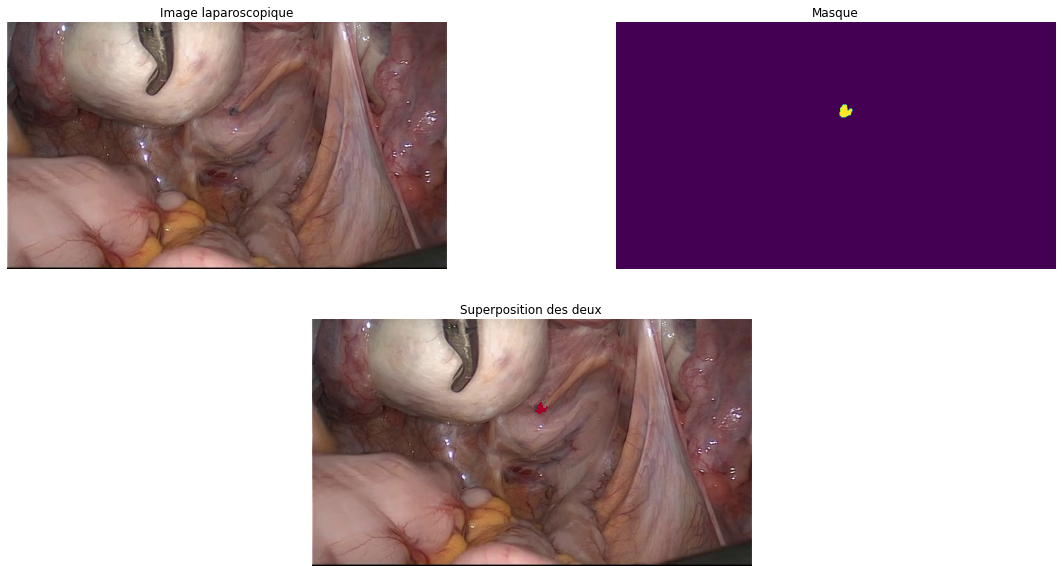

In [14]:
%matplotlib inline

df = pd.read_csv('run/dataset_final.csv', header=0)

row = 1000

image_path = df.iloc[row][0]
image = Image.open(image_path)
image_array = np.array(image)

mask_path = df.iloc[row][2]
mask = Image.open(mask_path)
mask_conv = mask.convert('L')
mask_array = np.array(mask_conv)

disp.plot3(image_array, mask_array)
